# Gaussian Mixture Models

## Preparación de ambiente

In [2]:
import pandas as pd
import cufflinks as cf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import davies_bouldin_score, silhouette_score

cf.go_offline()

### Funciones relevantes

In [3]:
def pivot_categories(df, cluster_column, categories):
    aux = df.copy()
    aux["dum"] = 1
    for i, col in enumerate(categories):
        agg_data = aux[[cluster_column, col, "dum"]].pivot_table(index = cluster_column, columns=col, aggfunc="sum", fill_value=0)
        agg_data.columns = [f"{col}_{x}" for x in agg_data.columns.droplevel(0)]
        total = agg_data.sum(axis=1)
        for col in agg_data:
            agg_data[col] /= total
        if i == 0:
            final = agg_data.copy()
        else:
            final = final.merge(agg_data, left_index = True, right_index = True, how = "inner")
    return final

## Data Wrangling

### Carga de datos

In [4]:
portfolio = pd.read_json('./starbucks/portfolio.json', orient='records', lines=True)
profile = pd.read_json('./starbucks/profile.json', orient='records', lines=True)
trx = pd.read_json('./starbucks/transcript.json', orient='records', lines=True)

In [5]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [6]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [7]:
trx

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


### EDA

In [8]:
print(trx.shape)
trx.head()

(306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [9]:
trx["event"].fillna("---").value_counts(True)

transaction        0.453304
offer received     0.248837
offer viewed       0.188315
offer completed    0.109544
Name: event, dtype: float64

In [10]:
print(portfolio.shape)
portfolio.head()

(10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


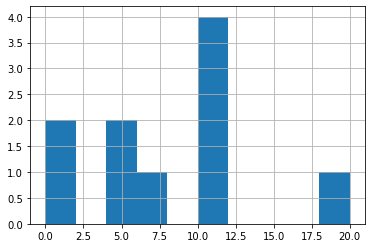

In [11]:
portfolio["difficulty"].hist()

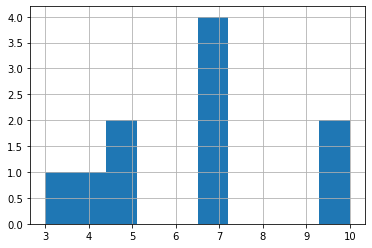

In [12]:
portfolio["duration"].hist()

In [13]:
portfolio["offer_type"].fillna("---").value_counts(True)

bogo             0.4
discount         0.4
informational    0.2
Name: offer_type, dtype: float64

In [14]:
print(profile.shape)
profile.head()

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [15]:
profile["gender"].fillna("----").value_counts(True)

M       0.499059
F       0.360529
----    0.127941
O       0.012471
Name: gender, dtype: float64

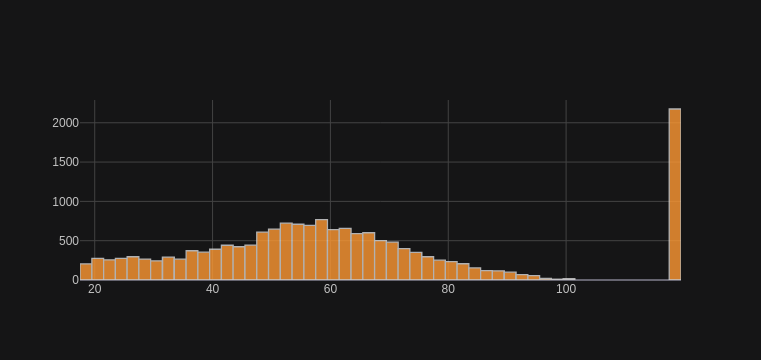

In [17]:
profile["age"].iplot(kind="hist", theme="solar")

In [18]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [19]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0


### Limpieza

In [20]:
profile["gender"].fillna("Missing", inplace=True)

In [22]:
profile[profile["income"].isnull()]

,gender,age,id,became_member_on,income
0,Missing,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
2,Missing,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
4,Missing,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN
6,Missing,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN
7,Missing,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN
...,...,...,...,...,...
16980,Missing,118,5c686d09ca4d475a8f750f2ba07e0440,2016-09-01,NaN
16982,Missing,118,d9ca82f550ac4ee58b6299cf1e5c824a,2016-04-15,NaN
16989,Missing,118,ca45ee1883624304bac1e4c8a114f045,2018-03-05,NaN
16991,Missing,118,a9a20fa8b5504360beb4e7c8712f8306,2016-01-16,NaN


In [23]:
profile = profile[profile["age"]<=100].reset_index(drop = True)

In [24]:
profile["age"].describe()

count    14820.000000
mean        54.377800
std         17.365541
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        100.000000
Name: age, dtype: float64

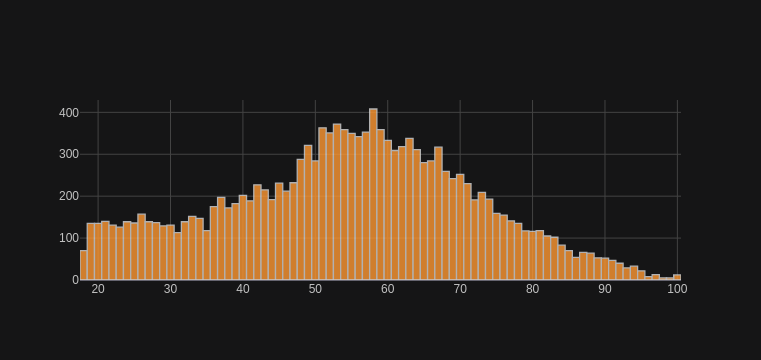

In [25]:
profile["age"].iplot(kind="hist", theme="solar")

In [26]:
trx[trx["event"] == "transaction"].sample(5)

,person,event,value,time
268678,7da737495ffd4370be31a6871bef5eb8,transaction,{'amount': 6.73},588
275595,024218e67fa549a4a0a99b32b7b6fbf9,transaction,{'amount': 19.64},606
52413,7ebd228eba9d45a08d23932227fc551c,transaction,{'amount': 12.1},162
223613,15a6fffc8d7b41c99d26209731abffb7,transaction,{'amount': 2.62},516
283208,81f948e3a4134729ba5c0e15d221ce5d,transaction,{'amount': 27.94},624


In [27]:
transactions = trx[trx["event"] == "transaction"]
transactions["amount"] = transactions["value"].map(lambda x:x["amount"])
transactions = transactions[["person", "amount", "time"]].groupby("person").agg({"amount": ["min", "max", "mean", "count", "sum"], "time": ["mean"]})
transactions.columns = ["_".join(x) for x in transactions.columns]
transactions.reset_index(drop = False, inplace=True)

In [28]:
transactions

,person,amount_min,amount_max,amount_mean,amount_count,amount_sum,time_mean
0,0009655768c64bdeb2e877511632db8f,8.57,28.16,15.950000,8,127.60,543.00
1,00116118485d4dfda04fdbaba9a87b5c,0.20,3.19,1.363333,3,4.09,408.00
2,0011e0d4e6b944f998e987f904e8c1e5,8.96,23.03,15.892000,5,79.46,451.20
3,0020c2b971eb4e9188eac86d93036a77,17.24,33.86,24.607500,8,196.86,348.75
4,0020ccbbb6d84e358d3414a3ff76cffd,6.81,20.08,12.837500,12,154.05,375.00
...,...,...,...,...,...,...,...
16573,fff3ba4757bd42088c044ca26d73817a,10.99,388.22,52.816364,11,580.98,246.00
16574,fff7576017104bcc8677a8d63322b5e1,2.08,8.01,4.990000,6,29.94,392.00
16575,fff8957ea8b240a6b5e634b6ee8eafcf,0.64,6.39,2.430000,5,12.15,379.20
16576,fffad4f4828548d1b5583907f2e9906b,2.05,12.18,7.402500,12,88.83,323.50


In [29]:
X = profile[["age", "income", "id"]].merge(transactions, left_on="id", right_on="person", how = "inner").drop(columns=["id"]).set_index("person")

In [30]:
X

,age,income,amount_min,amount_max,amount_mean,amount_count,amount_sum,time_mean
person,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,55,112000.0,21.51,32.28,25.670000,3,77.01,230.000000
78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,17.78,29.72,22.752857,7,159.27,308.571429
e2127556f4f64592b11af22de27a7932,68,70000.0,17.88,21.43,19.243333,3,57.73,368.000000
389bc3fa690240e798340f5a15918d5c,65,53000.0,9.54,15.63,12.143333,3,36.43,386.000000
2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,0.87,7.14,3.905000,4,15.62,405.000000
...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,45,54000.0,1.18,3.92,2.861429,7,20.03,319.714286
2cb4f97358b841b9a9773a7aa05a9d77,61,72000.0,2.24,6.46,3.710000,7,25.97,355.714286
01d26f638c274aa0b965d24cefe3183f,49,73000.0,1.74,8.26,4.967500,8,39.74,435.000000


In [31]:
vect = CountVectorizer(ngram_range=(1,1))

In [32]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [34]:
channels = pd.DataFrame(data=vect.fit_transform(portfolio["channels"].str.join(" ")).todense(), columns=vect.get_feature_names(), index=portfolio.index)
portfolio = portfolio.join(channels).drop(columns=["channels"])

In [35]:
portfolio

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [36]:
sc = MinMaxScaler()

In [37]:
Xs = pd.DataFrame(data=sc.fit_transform(X), columns=X.columns, index=X.index)

In [38]:
Xs

,age,income,amount_min,amount_max,amount_mean,amount_count,amount_sum,time_mean
person,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,0.451220,0.911111,0.428943,0.030251,0.056545,0.057143,0.047782,0.310541
78afa995795e4d85b5d9ceeca43f5fef,0.695122,0.777778,0.354387,0.027840,0.050082,0.171429,0.098922,0.422466
e2127556f4f64592b11af22de27a7932,0.609756,0.444444,0.356386,0.020035,0.042306,0.057143,0.035796,0.507123
389bc3fa690240e798340f5a15918d5c,0.573171,0.255556,0.189686,0.014574,0.026574,0.057143,0.022555,0.532764
2eeac8d8feae4a8cad5a6af0499a211d,0.487805,0.233333,0.016390,0.006581,0.008320,0.085714,0.009617,0.559829
...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,0.329268,0.266667,0.022586,0.003549,0.006008,0.171429,0.012359,0.438339
2cb4f97358b841b9a9773a7aa05a9d77,0.524390,0.466667,0.043774,0.005941,0.007888,0.171429,0.016052,0.489621
01d26f638c274aa0b965d24cefe3183f,0.378049,0.477778,0.033780,0.007636,0.010674,0.200000,0.024612,0.602564


In [39]:
pca = PCA(n_components=3)

In [40]:
Xp = pd.DataFrame(data=pca.fit_transform(Xs), columns=["p1", "p2", "p3"], index=Xs.index)

In [41]:
pca.explained_variance_ratio_.cumsum()

array([0.48558528, 0.69101127, 0.82102765])

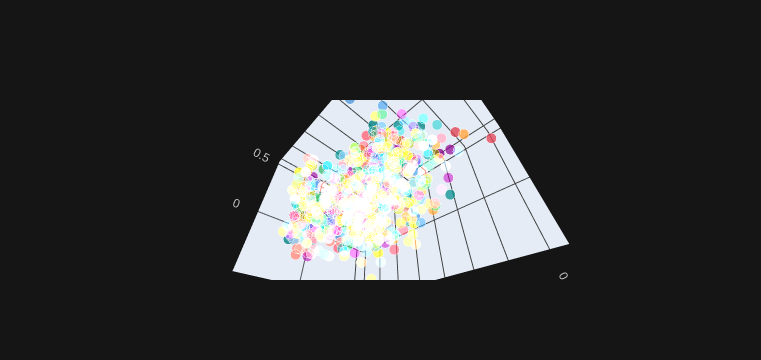

In [42]:
Xp.sample(frac=0.05).iplot(kind="scatter3d", mode="markers", x="p1", y="p2", z="p3", theme="solar")

In [43]:
sse,db,slc = {}, {}, {}
for k in range(2, 15):
    cluster = GaussianMixture(n_components=k, random_state=10).fit(Xs)
    clusters = cluster.predict(Xs)
    db[k] = davies_bouldin_score(Xs,clusters)
    slc[k] = silhouette_score(Xs,clusters)

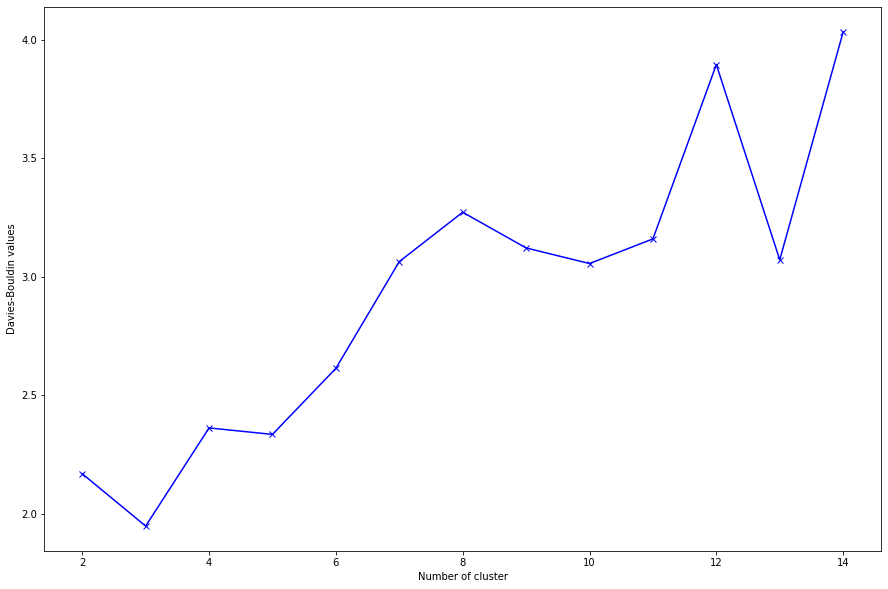

In [44]:
plt.figure(figsize=(15,10))
plt.plot(list(db.keys()), list(db.values()), "bx-")
plt.xlabel("Number of cluster")
plt.ylabel("Davies-Bouldin values")
plt.show()

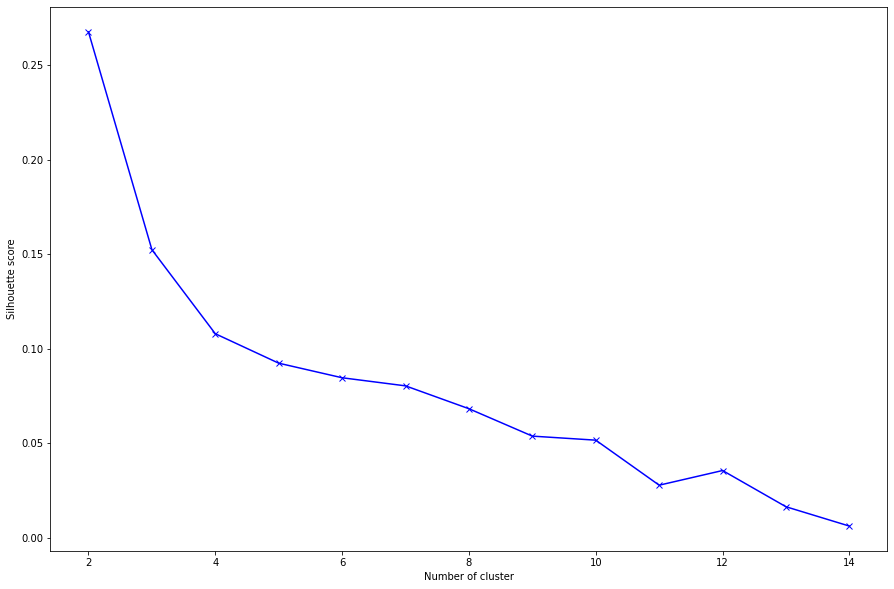

In [45]:
plt.figure(figsize=(15,10))
plt.plot(list(slc.keys()), list(slc.values()), "bx-")
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette score")
plt.show()

In [46]:
GaussianMixture?

Init signature:
GaussianMixture(
    n_components=1,
    *,
    covariance_type='full',
    tol=0.001,
    reg_covar=1e-06,
    max_iter=100,
    n_init=1,
    init_params='kmeans',
    weights_init=None,
    means_init=None,
    precisions_init=None,
    random_state=None,
    warm_start=False,
    verbose=0,
    verbose_interval=10,
)
Docstring:     
Gaussian Mixture.

Representation of a Gaussian mixture model probability distribution.
This class allows to estimate the parameters of a Gaussian mixture
distribution.

Read more in the :ref:`User Guide <gmm>`.

.. versionadded:: 0.18

Parameters
----------
n_components : int, default=1
    The number of mixture components.

covariance_type : {'full', 'tied', 'diag', 'spherical'}, default='full'
    String describing the type of covariance parameters to use.
    Must be one of:

    'full'
        each component has its own general covariance matrix
    'tied'
        all components share the same general covariance matrix
    'diag'
  

In [47]:
cluster = GaussianMixture(n_components=3, random_state=10)

cluster.fit(Xs)

X["cl"] = Xs["cl"] = Xp["cl"] = [str(x) for x in cluster.predict(Xs)]

Xp.sample(frac=0.1).iplot(kind="scatter3d", mode="markers", x="p1", y="p2", z="p3", categories="cl", theme="solar")

In [51]:
X["cl"].value_counts(True)

2    0.637951
0    0.318078
1    0.043970
Name: cl, dtype: float64

In [69]:
profile

,gender,age,id,became_member_on,income
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0
...,...,...,...,...,...
14815,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0
14816,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0
14817,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0
14818,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0


In [53]:
X.groupby("cl").mean().join(pivot_categories(df=X.join(profile.set_index("id")[["gender"]]), categories=["gender"], cluster_column="cl")).style.background_gradient(cmap='Blues')

,age,income,amount_min,amount_max,amount_mean,amount_count,amount_sum,time_mean,gender_F,gender_M,gender_O
cl,,,,,,,,,,,
0,47.779731,50750.434028,0.788099,7.205154,3.142818,9.124132,28.993468,394.278622,0.196832,0.794488,0.008681
1,51.896389,59649.921507,6.484600,334.350031,51.837501,12.532182,460.159812,377.316306,0.376766,0.612245,0.010989
2,57.700931,72814.001298,11.933807,27.228844,18.766147,7.994265,141.456478,388.135897,0.523804,0.459208,0.016988


In [54]:
offers = trx[trx["event"] != "transaction"]

In [55]:
offers

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},714
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714


In [56]:
offers["offer"] = offers["value"].map(lambda x:x["offer_id"] if "offer_id" in x.keys() else x["offer id"])

In [57]:
offers

,person,event,value,time,offer
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714,2298d6c36e964ae4a3e7e9706d1fb8c2
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,fafdcd668e3743c1bb461111dcafc2a4
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},714,0b1e1539f2cc45b7b9fa7c272da2e1d7
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,fafdcd668e3743c1bb461111dcafc2a4


In [58]:
portfolio

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [59]:
offers = offers.merge(portfolio, left_on="offer", right_on="id")[["person", "event", "offer_type", "email", "mobile", "social", "web"]]

In [60]:
offers

,person,event,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,bogo,1,1,0,1
1,ebe7ef46ea6f4963a7dd49f501b26779,offer received,bogo,1,1,0,1
2,f082d80f0aac47a99173ba8ef8fc1909,offer received,bogo,1,1,0,1
3,c0d210398dee4a0895b24444a5fcd1d2,offer received,bogo,1,1,0,1
4,57dd18ec5ddc46828afb81ec5977bef2,offer received,bogo,1,1,0,1
...,...,...,...,...,...,...,...
167576,642b6f1bf61040efb73e1859cf00e79e,offer viewed,informational,1,1,1,0
167577,5a3f7fcb450a4cb693ab5267b4d49b40,offer viewed,informational,1,1,1,0
167578,ec1761735b034ae8874bc979f0cd5862,offer viewed,informational,1,1,1,0
167579,d56386cf344c4829bbf420d1895dca37,offer viewed,informational,1,1,1,0


In [61]:
full = X[["cl"]].reset_index().merge(offers, on="person")

In [62]:
full

,person,cl,event,offer_type,email,mobile,social,web
0,0610b486422d4921ae7d2bf64640c50b,2,offer received,bogo,1,1,0,1
1,0610b486422d4921ae7d2bf64640c50b,2,offer completed,bogo,1,1,0,1
2,0610b486422d4921ae7d2bf64640c50b,2,offer received,informational,1,1,0,1
3,78afa995795e4d85b5d9ceeca43f5fef,2,offer received,bogo,1,1,0,1
4,78afa995795e4d85b5d9ceeca43f5fef,2,offer viewed,bogo,1,1,0,1
...,...,...,...,...,...,...,...,...
146132,e4052622e5ba45a8b96b59aba68cf068,2,offer received,discount,1,1,1,1
146133,e4052622e5ba45a8b96b59aba68cf068,2,offer viewed,discount,1,1,1,1
146134,e4052622e5ba45a8b96b59aba68cf068,2,offer completed,discount,1,1,1,1
146135,e4052622e5ba45a8b96b59aba68cf068,2,offer received,informational,1,1,0,1


In [63]:
full["dum"] = 1

In [64]:
for offer_type in full["offer_type"].unique():
    print(f"Clusters' reponse rates by {offer_type}")
    display(pivot_categories(df=full[full["offer_type"] == offer_type], categories=["event"], cluster_column="cl").style.background_gradient(cmap='Blues'))

Clusters' reponse rates by bogo


,event_offer completed,event_offer received,event_offer viewed
cl,,,
0,0.090960,0.509883,0.399157
1,0.279608,0.393148,0.327243
2,0.296651,0.379307,0.324042


Clusters' reponse rates by informational


,event_offer received,event_offer viewed
cl,,
0,0.629664,0.370336
1,0.578610,0.421390
2,0.569096,0.430904


Clusters' reponse rates by discount


,event_offer completed,event_offer received,event_offer viewed
cl,,,
0,0.177326,0.528217,0.294457
1,0.324068,0.389143,0.286789
2,0.316659,0.388943,0.294398
